## Import library

In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchmetrics

import numpy as np
import pandas as pd

import albumentations
import albumentations.pytorch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm

## Download dataset

In [2]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('sorour/38cloud-cloud-segmentation-in-satellite-images', path='dataset', unzip=True)

## Configurations

In [3]:
!nvidia-smi

Thu Dec  1 21:33:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 41%   47C    P8    27W / 260W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 41%   

In [4]:
BASE_DIR = 'dataset'
TRAIN_DIR = f'{BASE_DIR}/38-Cloud_training'
TEST_DIR = f'{BASE_DIR}/38-Cloud_test'
TRAIN_PATCHES_FILE = f'{BASE_DIR}/training_patches_38-cloud_nonempty.csv'
TEST_PATCHES_FILE = f'{TEST_DIR}/test_patches_38-Cloud.csv'
BATCH_SIZE = 12
NUM_EPOCHS = 20
LOW_TRAINABLE_THRESHOLD = 0.03
HIGH_TRAINABLE_THRESHOLD = 0.97
LEARNING_RATE = 1e-4

torch.manual_seed(42)
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(7)
print(torch.cuda.current_device())

7


## Import Dataset

In [6]:
class CreateCloudDataset():
    def __init__(self):
        self.transform = albumentations.Compose([
            albumentations.Normalize(mean=[0.0], std=[1.0], max_pixel_value=65535.0),
            albumentations.Resize(192, 192),
            albumentations.pytorch.ToTensorV2()
        ])
        self.train_patches = pd.read_csv(TRAIN_PATCHES_FILE)
        self.test_patches = pd.read_csv(TEST_PATCHES_FILE)

    def import_dataset(self, patches, is_train):
        if is_train:
            bands = ['nir', 'red', 'green', 'blue', 'gt']
            bands_path = [f"{TRAIN_DIR}/train_{x}/{x}_" for x in bands]
        else:
            bands = ['nir', 'red', 'green', 'blue']
            bands_path = [f"{TEST_DIR}/test_{x}/{x}_" for x in bands]
            
        dataset = []
        ratio_non_zero_map = {}
        

        for i in tqdm(range(len(patches))):
            image_file_name = patches.iloc[i][0]
            bands_file_name = [f"{x}{image_file_name}.TIF" for x in bands_path]
            all_bands = []
            for x in bands_file_name:
                im = Image.open(x)
                image = np.array(im, dtype=np.float32)
                im.close()
                all_bands.append(self.transform(image=image)['image'])
            non_zero = torch.count_nonzero(all_bands[-1])
            ratio_non_zero = non_zero.item()/(192*192)
            
            rounded_ratio_non_zero = round(ratio_non_zero, 1)
            if rounded_ratio_non_zero not in ratio_non_zero_map:
                ratio_non_zero_map[rounded_ratio_non_zero] = 1
            else:
                ratio_non_zero_map[rounded_ratio_non_zero] += 1
            
            if ratio_non_zero < LOW_TRAINABLE_THRESHOLD or ratio_non_zero > HIGH_TRAINABLE_THRESHOLD:
                continue
            image = torch.cat((all_bands[0], all_bands[1], all_bands[2], all_bands[3]), dim=0)
            if is_train:
                label = all_bands[-1]
                label[label > 0] = 1.0
                dataset.append((image, label))
            else:
                dataset.append((image, image_file_name)) 
                
        ratio_non_zero_key = list(ratio_non_zero_map.keys())
        ratio_non_zero_val = list(ratio_non_zero_map.values())
        plt.bar(range(len(ratio_non_zero_map)), ratio_non_zero_val, tick_label=ratio_non_zero_key)
        plt.show()
        return dataset

class CloudTrainDataset():
    def __init__(self, dataset):
            self.dataset = dataset
            self.train_dataset, self.valid_dataset = self.split(train_ratio=0.8)
            self.train_dataset = self.create_batch(self.train_dataset, BATCH_SIZE, shuffle=True)
            self.valid_dataset = self.create_batch(self.valid_dataset, BATCH_SIZE, shuffle=False)
    
    def split(self, train_ratio):
            train_size = int(train_ratio * len(self.dataset))
            valid_size = len(self.dataset) - train_size
            return random_split(self.dataset, [train_size, valid_size])

    def create_batch(self, data, batch_size, shuffle):
            return DataLoader(data, batch_size=batch_size, shuffle=shuffle)
        
class CloudTestDataset():
    def __init__(self, dataset):
            self.dataset = dataset
            self.test_dataset = self.create_batch(self.test_dataset, BATCH_SIZE, shuffle=False)

    def create_batch(self, data, batch_size, shuffle):
            return DataLoader(data, batch_size=batch_size, shuffle=shuffle)  

100%|███████████████████████████████████████████████████████████████████████████████| 5155/5155 [02:31<00:00, 34.10it/s]


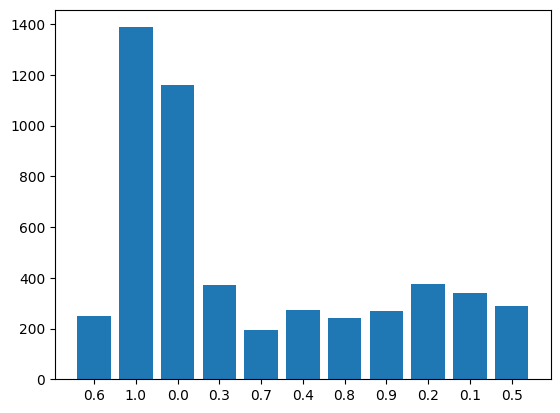

In [7]:
ds = CreateCloudDataset()
train_dataset = ds.import_dataset(ds.train_patches, is_train=True)

In [8]:
len(train_dataset)

2788

In [9]:
dataset = CloudTrainDataset(train_dataset)

## Preview Dataset

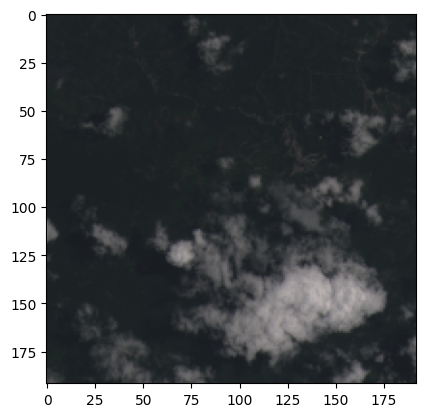

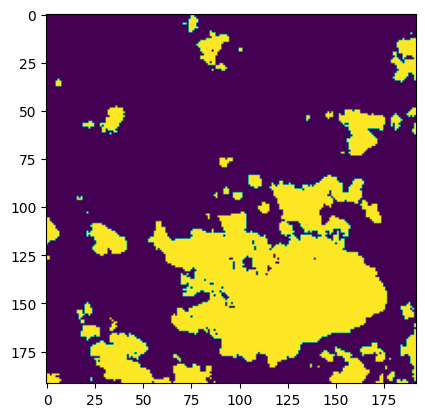

In [10]:
for img, label in dataset.train_dataset:
    img = img[0]
    label = label[0]
    img = np.dstack((img[1], img[2], img[3]))
    label = label.swapaxes(0,1).swapaxes(1,2)
    plt.imshow(img)
    plt.show()
    plt.imshow(label)
    plt.show()
    break

## Define Metrics

In [11]:
class Metrics():
    def __init__(self):
        self.loss = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0
        self.accuracy = 0.0
        self.iou = 0.0
        
    def avg_compute_fn(self, previous_metric_value, added_value, length):
        return (previous_metric_value * length + added_value) / (length+1)

    def compute_loss(self, loss, idx):
        self.loss = self.avg_compute_fn(self.loss, loss, idx)

    def compute_metrics(self, y_pred, y_true, idx):
        self.precision  = self.avg_compute_fn(self.precision, torchmetrics.functional.classification.binary_precision(y_pred, y_true).item(), idx)
        self.recall     = self.avg_compute_fn(self.recall, torchmetrics.functional.classification.binary_recall(y_pred, y_true).item(), idx)
        self.f1         = self.avg_compute_fn(self.f1, torchmetrics.functional.classification.binary_f1_score(y_pred, y_true).item(), idx)
        self.accuracy   = self.avg_compute_fn(self.accuracy, torchmetrics.functional.classification.binary_accuracy(y_pred, y_true).item(), idx)
        self.iou        = self.avg_compute_fn(self.iou, torchmetrics.functional.classification.binary_jaccard_index(y_pred, y_true).item(), idx)

    def print(self, type):
        print(f"[{type}] Loss: {self.loss:.4f},"
            f"   Precision: {self.precision:.4f},"
            f"   Recall: {self.recall:.4f},"
            f"   F1: {self.f1:.4f},"
            f"   Accuracy: {self.accuracy:.4f}," 
            f"   IoU: {self.iou:.4f}")

## Build Model

In [12]:
def fit(model, train_data, valid_data, loss_fn, optimizer):
    best_iou = 0.0
    best_metric = None
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_data)
        metrics = Metrics()
        model.train()
        
        for idx, (images, labels) in enumerate(loop):
            images = images.cuda()
            labels = labels.cuda()
            predict = model(images)
            loss = loss_fn(predict, labels)
            metrics.compute_loss(loss.item(), idx)
            metrics.compute_metrics(predict, labels.int(), idx)
            loop.set_postfix(loss=metrics.loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"[Epoch] {epoch}")
        metrics.print("Train")

        with torch.no_grad():
            metrics = Metrics()
            model.eval()
            for idx, (images, labels) in enumerate(valid_data):
                images = images.cuda()
                labels = labels.cuda()
                predict = model(images)
                loss = loss_fn(predict, labels)
                metrics.compute_loss(loss.item(), idx)
                metrics.compute_metrics(predict, labels.int(), idx)
            metrics.print("Valid")
            
            if metrics.iou > best_iou:
                best_iou = metrics.iou
                best_metric = metrics
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn,
                    }, 'checkpoint_unet.pt')
    return best_metric

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.transposed = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv = DoubleConv(in_channels, out_channels)
        
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU()
        )
        
    def forward(self, skip_connect, x):
        x = self.transposed(x)
        
        if x.shape != skip_connect.shape:
            x = TF.resize(x, size=skip_connect.shape[2:])
        x = torch.cat([skip_connect, x], dim=1)
        x = self.bn_relu(x)
        x = self.conv(x)
        return x
            

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList([
            DoubleConv(in_channels, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512),
        ])
        self.bottle_neck = DoubleConv(512, 1024)
        
        self.ups = nn.ModuleList([
            UpBlock(1024, 512),
            UpBlock(512, 256),
            UpBlock(256, 128),
            UpBlock(128, 64),
        ])

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1,stride=1,padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        skip_layer = []
        
        for idx, down_layer in enumerate(self.downs):
            x = down_layer(x)
            skip_layer.append(x)
            x = self.pool(x)
            
        x = self.bottle_neck(x)
        
        skip_layer = skip_layer[::-1]
        for idx, up_layer in enumerate(self.ups):
            skip = skip_layer[idx]
            x = up_layer(skip, x)
            
        x = self.final_conv(x)
        return x     

## Train Model

In [14]:
model = UNET(in_channels=4, out_channels=1)
model = nn.DataParallel(model, device_ids = [7, 1])
model.cuda()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
best = fit(model, dataset.train_dataset, dataset.valid_dataset, loss_fn, optimizer)

100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:50<00:00,  3.72it/s, loss=0.377]


[Epoch] 0
[Train] Loss: 0.3766,   Precision: 0.8170,   Recall: 0.8463,   F1: 0.8256,   Accuracy: 0.8376,   IoU: 0.7079
[Valid] Loss: 0.2710,   Precision: 0.8976,   Recall: 0.8499,   F1: 0.8711,   Accuracy: 0.8909,   IoU: 0.7750


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.71it/s, loss=0.307]


[Epoch] 1
[Train] Loss: 0.3065,   Precision: 0.8594,   Recall: 0.8723,   F1: 0.8621,   Accuracy: 0.8741,   IoU: 0.7605
[Valid] Loss: 0.3471,   Precision: 0.9476,   Recall: 0.6609,   F1: 0.7748,   Accuracy: 0.8349,   IoU: 0.6373


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.77it/s, loss=0.284]


[Epoch] 2
[Train] Loss: 0.2838,   Precision: 0.8701,   Recall: 0.8867,   F1: 0.8744,   Accuracy: 0.8853,   IoU: 0.7798
[Valid] Loss: 0.3031,   Precision: 0.9290,   Recall: 0.7544,   F1: 0.8295,   Accuracy: 0.8660,   IoU: 0.7123


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.80it/s, loss=0.257]


[Epoch] 3
[Train] Loss: 0.2572,   Precision: 0.8853,   Recall: 0.8929,   F1: 0.8864,   Accuracy: 0.8971,   IoU: 0.7986
[Valid] Loss: 0.2430,   Precision: 0.8599,   Recall: 0.9229,   F1: 0.8882,   Accuracy: 0.8996,   IoU: 0.8025


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.80it/s, loss=0.241]


[Epoch] 4
[Train] Loss: 0.2408,   Precision: 0.8926,   Recall: 0.8994,   F1: 0.8937,   Accuracy: 0.9033,   IoU: 0.8100
[Valid] Loss: 0.2428,   Precision: 0.8779,   Recall: 0.9075,   F1: 0.8907,   Accuracy: 0.9042,   IoU: 0.8059


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.60it/s, loss=0.244]


[Epoch] 5
[Train] Loss: 0.2439,   Precision: 0.8907,   Recall: 0.8991,   F1: 0.8925,   Accuracy: 0.9025,   IoU: 0.8080
[Valid] Loss: 0.2554,   Precision: 0.9085,   Recall: 0.8405,   F1: 0.8713,   Accuracy: 0.8921,   IoU: 0.7752


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:41<00:00,  4.50it/s, loss=0.231]


[Epoch] 6
[Train] Loss: 0.2310,   Precision: 0.8916,   Recall: 0.9062,   F1: 0.8961,   Accuracy: 0.9055,   IoU: 0.8140
[Valid] Loss: 0.1986,   Precision: 0.9022,   Recall: 0.9133,   F1: 0.9064,   Accuracy: 0.9186,   IoU: 0.8308


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:41<00:00,  4.50it/s, loss=0.22]


[Epoch] 7
[Train] Loss: 0.2196,   Precision: 0.9011,   Recall: 0.9065,   F1: 0.9020,   Accuracy: 0.9113,   IoU: 0.8239
[Valid] Loss: 0.1957,   Precision: 0.9253,   Recall: 0.8912,   F1: 0.9067,   Accuracy: 0.9206,   IoU: 0.8310


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.79it/s, loss=0.211]


[Epoch] 8
[Train] Loss: 0.2110,   Precision: 0.9046,   Recall: 0.9094,   F1: 0.9050,   Accuracy: 0.9143,   IoU: 0.8283
[Valid] Loss: 0.1922,   Precision: 0.9364,   Recall: 0.8892,   F1: 0.9111,   Accuracy: 0.9249,   IoU: 0.8380


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.70it/s, loss=0.213]


[Epoch] 9
[Train] Loss: 0.2134,   Precision: 0.9044,   Recall: 0.9053,   F1: 0.9028,   Accuracy: 0.9122,   IoU: 0.8250
[Valid] Loss: 0.1977,   Precision: 0.8981,   Recall: 0.9290,   F1: 0.9118,   Accuracy: 0.9222,   IoU: 0.8397


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.65it/s, loss=0.204]


[Epoch] 10
[Train] Loss: 0.2035,   Precision: 0.9077,   Recall: 0.9109,   F1: 0.9073,   Accuracy: 0.9166,   IoU: 0.8323
[Valid] Loss: 0.1802,   Precision: 0.9016,   Recall: 0.9333,   F1: 0.9159,   Accuracy: 0.9258,   IoU: 0.8466


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.85it/s, loss=0.198]


[Epoch] 11
[Train] Loss: 0.1982,   Precision: 0.9128,   Recall: 0.9124,   F1: 0.9108,   Accuracy: 0.9198,   IoU: 0.8382
[Valid] Loss: 0.1860,   Precision: 0.9383,   Recall: 0.8876,   F1: 0.9113,   Accuracy: 0.9251,   IoU: 0.8384


100%|███████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.69it/s, loss=0.2]


[Epoch] 12
[Train] Loss: 0.2004,   Precision: 0.9132,   Recall: 0.9081,   F1: 0.9089,   Accuracy: 0.9183,   IoU: 0.8347
[Valid] Loss: 0.1772,   Precision: 0.9189,   Recall: 0.9112,   F1: 0.9136,   Accuracy: 0.9254,   IoU: 0.8428


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:41<00:00,  4.51it/s, loss=0.19]


[Epoch] 13
[Train] Loss: 0.1897,   Precision: 0.9173,   Recall: 0.9149,   F1: 0.9148,   Accuracy: 0.9226,   IoU: 0.8443
[Valid] Loss: 0.1893,   Precision: 0.8923,   Recall: 0.9269,   F1: 0.9079,   Accuracy: 0.9190,   IoU: 0.8337


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.79it/s, loss=0.189]


[Epoch] 14
[Train] Loss: 0.1895,   Precision: 0.9164,   Recall: 0.9124,   F1: 0.9128,   Accuracy: 0.9220,   IoU: 0.8412
[Valid] Loss: 0.1749,   Precision: 0.9097,   Recall: 0.9249,   F1: 0.9159,   Accuracy: 0.9261,   IoU: 0.8463


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.65it/s, loss=0.182]


[Epoch] 15
[Train] Loss: 0.1821,   Precision: 0.9202,   Recall: 0.9162,   F1: 0.9166,   Accuracy: 0.9250,   IoU: 0.8476
[Valid] Loss: 0.1922,   Precision: 0.9284,   Recall: 0.8967,   F1: 0.9112,   Accuracy: 0.9241,   IoU: 0.8382


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.61it/s, loss=0.174]


[Epoch] 16
[Train] Loss: 0.1743,   Precision: 0.9251,   Recall: 0.9178,   F1: 0.9201,   Accuracy: 0.9284,   IoU: 0.8535
[Valid] Loss: 0.1628,   Precision: 0.9394,   Recall: 0.9052,   F1: 0.9209,   Accuracy: 0.9327,   IoU: 0.8547


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.81it/s, loss=0.175]


[Epoch] 17
[Train] Loss: 0.1753,   Precision: 0.9211,   Recall: 0.9188,   F1: 0.9185,   Accuracy: 0.9271,   IoU: 0.8505
[Valid] Loss: 0.1718,   Precision: 0.9091,   Recall: 0.9334,   F1: 0.9200,   Accuracy: 0.9297,   IoU: 0.8533


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.64it/s, loss=0.173]


[Epoch] 18
[Train] Loss: 0.1725,   Precision: 0.9261,   Recall: 0.9186,   F1: 0.9211,   Accuracy: 0.9294,   IoU: 0.8550
[Valid] Loss: 0.1664,   Precision: 0.9241,   Recall: 0.9172,   F1: 0.9194,   Accuracy: 0.9302,   IoU: 0.8520


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.65it/s, loss=0.175]


[Epoch] 19
[Train] Loss: 0.1749,   Precision: 0.9239,   Recall: 0.9169,   F1: 0.9189,   Accuracy: 0.9282,   IoU: 0.8520
[Valid] Loss: 0.1786,   Precision: 0.8926,   Recall: 0.9354,   F1: 0.9120,   Accuracy: 0.9218,   IoU: 0.8404


In [15]:
best.print("Best")

[Best] Loss: 0.1628,   Precision: 0.9394,   Recall: 0.9052,   F1: 0.9209,   Accuracy: 0.9327,   IoU: 0.8547


In [16]:
model.load_state_dict(torch.load('checkpoint_unet.pt')['model_state_dict'])

<All keys matched successfully>

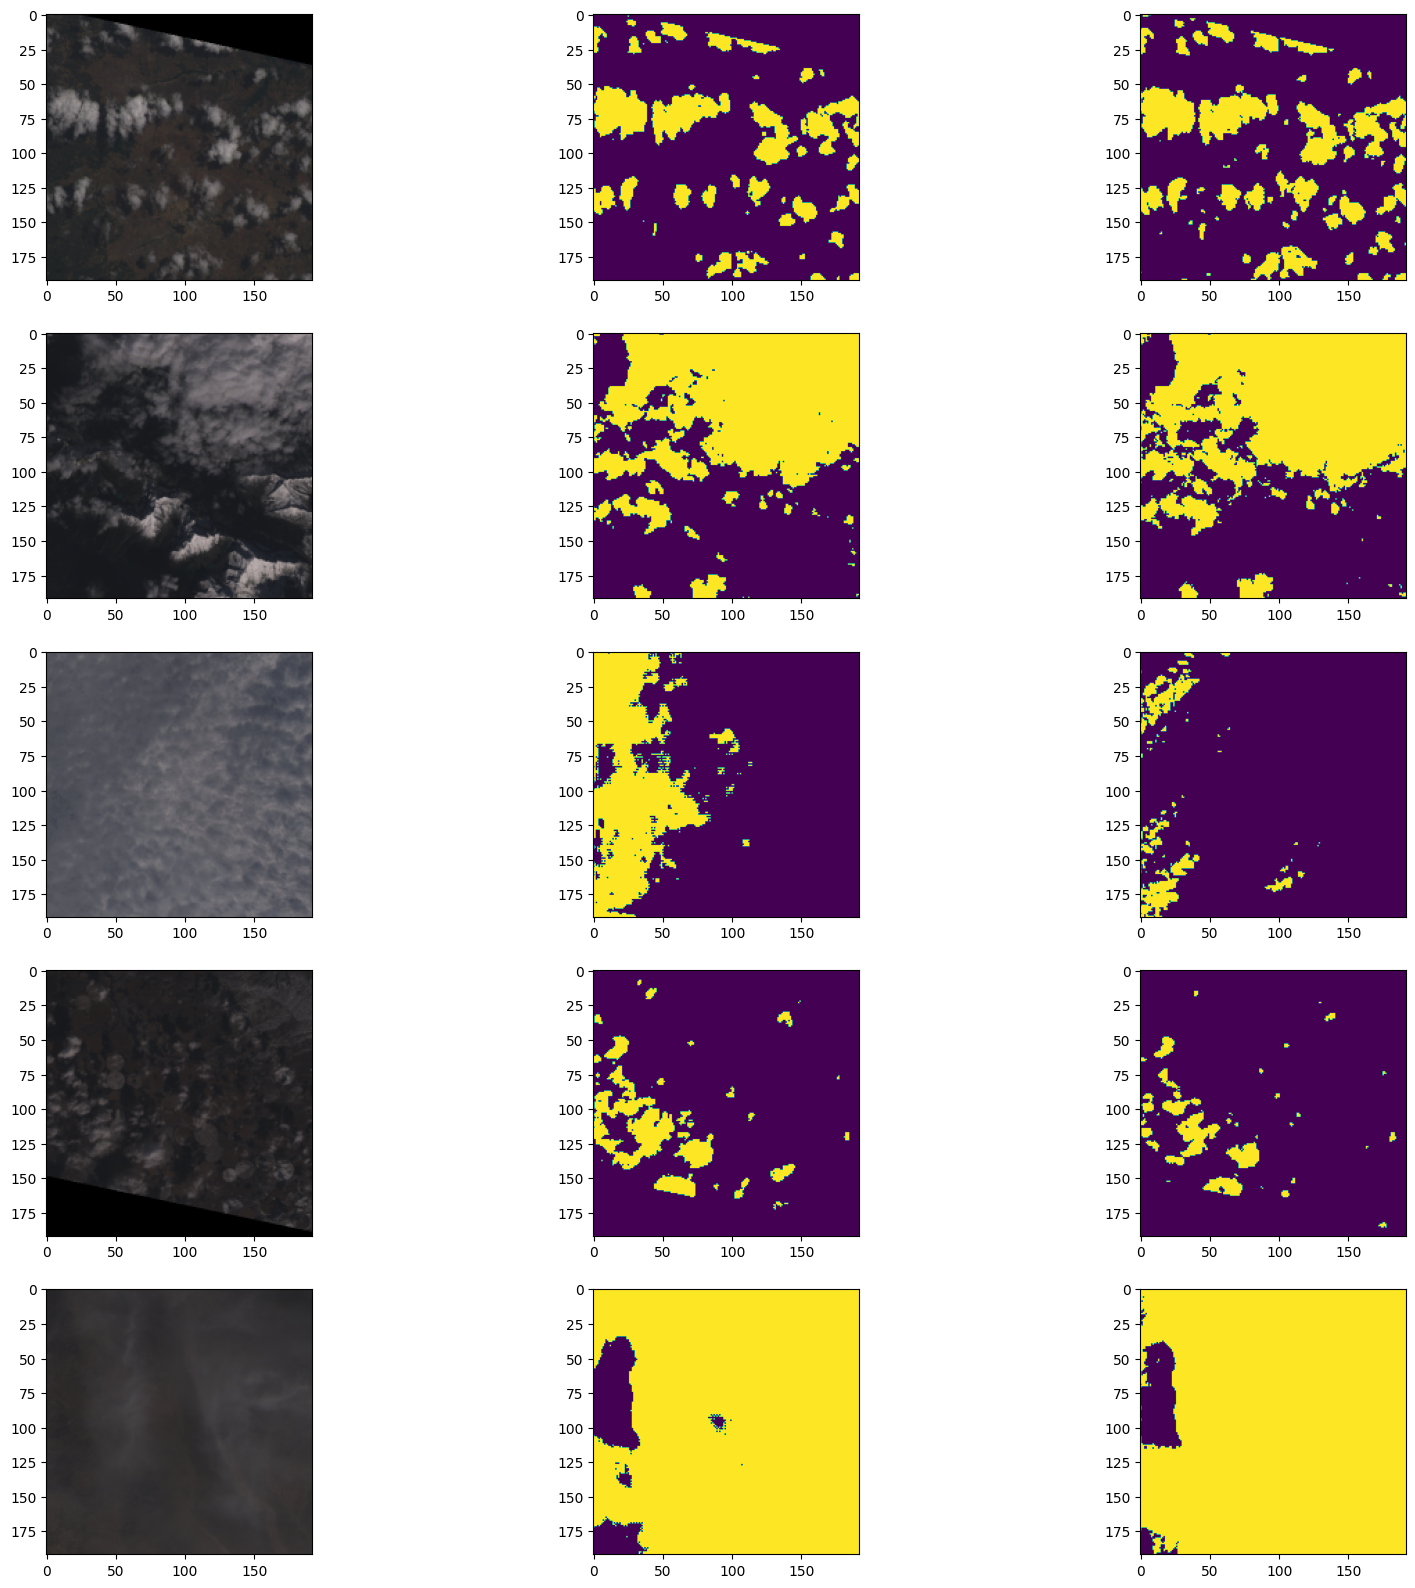

In [17]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))

for img, label in dataset.valid_dataset:
    cnt += 1
    image = np.dstack((img[0][1], img[0][2], img[0][3]))
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(image)
   
    preds = model(img.cuda())
    preds = (preds > 0.5).float()
    predict = preds[0].swapaxes(0,1)
    predict = predict.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(predict.cpu().detach().numpy())

    labels = label[0].swapaxes(0,1)
    labels = labels.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(labels)

    if cnt == 5: break
plt.show()    